## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import heapq
import mplcursors

## Heap

In [2]:
# Use a max heap of n elements, popping when the new element is less than the head
class KMaxHeap():
  def __init__(self, capacity):
    self.capacity = capacity
    self.data = [] 

  def push(self, elem):
    elem[0] = -elem[0]
    if len(self.data) < self.capacity:
      heapq.heappush(self.data, elem)
    elif elem[0] > self.data[0][0]:
      heapq.heappushpop(self.data, elem)

## BirdFlockSimulator

In [3]:
class NearestNeighbourCalculator:
  
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN
  
  def getNNDf(self, df):
    res = []
    for i in range(len(df)):
      res.append(self.getNeighbours(i, df))
    nndf = pd.DataFrame(np.array(res))
    nndf = nndf.rename(mapper=self.mapColNames, axis='columns')
    return pd.concat([df, nndf], axis='columns')

  # Nearest Neighbours
  def getNeighbours(self, i, df):
    bird = df.iloc[i]
    maxHeap = KMaxHeap(self.neighboursN)
    for index, row in df.iterrows():
      if i == index:
        continue
      dist = abs(row.x-bird.x) ** 2 + abs(row.y-bird.y) ** 2
      maxHeap.push([dist, row])
    maxHeap.data.sort()
    nn = np.array(
      [[math.sqrt(-x[0]), x[1][0], x[1][1]]
      for x in reversed(maxHeap.data)]).flatten()
    return nn

  def mapColNames(self, col):
    nnn = col//3
    label = ""
    if col % 3 == 0:
      label = "dist"
    elif col % 3 == 1:
      label = "x"
    else:
      label = "y"
    return f"nn_{nnn}_{label}"
  

In [26]:
class VectorCalculator:
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN

  # Vector calculation
  def getVectors(self, df):
    # Calculate vector based on NN
    vectorData = []
    for index, row in df.iterrows():
      newXVector = 0.0
      newYVector = 0.0
      individualXVectors = []
      individualYVectors = []
      for i in range(self.neighboursN):
        xDiff, yDiff = self.calcVector(row, (row[f"nn_{i}_x"], row[f"nn_{i}_y"], row[f"nn_{i}_dist"]))
        newXVector += xDiff
        newYVector += yDiff
        individualXVectors.append(xDiff)
        individualYVectors.append(yDiff)

      # This should be replaced with a momentum model
      xVector = (newXVector + row.vx) / 2
      yVector = (newYVector + row.vy) / 2
      # Floor velocity to 5
      if (xVector **2) + (yVector ** 2) < 5:
        xVector, yVector = self.normalizeVector(xVector, yVector, math.sqrt(5))

      # Take vectors and combine with current velocity
      vectorData.append(np.array([xVector, yVector]))
    ret = pd.DataFrame(np.array(vectorData))
    ret.columns = ["x", "y"]
    display(ret)
    return ret
  
  # Alternative, use the vectors of the 5 closest neightbours instead?
  def calcVector(self, bird, neighbour):
    neighbourX, neighbourY, neighbourDist = neighbour
    vecX = neighbourX-bird.x
    vecY = neighbourY-bird.y
    # If neighbour is greater than 15, we want to be attracted to a point 10 away
    if neighbourDist >= 15:
      attraction = neighbourDist-10
      attractionFactor = 0.1
      return self.normalizeVector(vecX, vecY, attraction*attractionFactor)
    # If neighbour is less than 10, repulse them based on how close they are
    # Push away linearly
    elif neighbourDist <= 5:
      repulsion = 10-neighbourDist
      repulsionFactor = 0.1
      return self.normalizeVector(-vecX, -vecY, repulsion*repulsionFactor)
    # Else, maintain current vector
    else:
      return (0, 0)
  
  def normalizeVector(self, x, y, scale=1):
    hyp = math.sqrt(x**2 + y**2)
    return ((x/hyp)*scale, (y/hyp)*scale)

In [27]:
class BirdFlockSimulator:

  # Init
  def __init__(self, numBirds):
    self.numBirds = numBirds
    self.maxX = 100
    self.maxY = 100
    self.neighboursN = 5
    self.birds = self.createBirdsDataframe()
    self.next = None

  def createBirdsDataframe(self):
    d = {
      'x': np.random.rand(self.numBirds) * self.maxX,
      'y': np.random.rand(self.numBirds) * self.maxY,
      'vx' : np.random.rand(self.numBirds) * 10,
      'vy' : np.random.rand(self.numBirds) * 10
    }
    return pd.DataFrame(data=d)

  def getNext(self):
    if self.next is None:
      self.next = self.calculateTick()
    return self.next[1]

  def tick(self, update=True):
    self.getNext()
    if update:
      self.birds, self.nnDf = self.next
      self.next = None

  def calculateTick(self):
    # NN
    nnCalc = NearestNeighbourCalculator(self.neighboursN)
    nnDf = nnCalc.getNNDf(self.birds)
    # Vectors
    vCalc = VectorCalculator(self.neighboursN)
    vectors = vCalc.getVectors(nnDf)

    # Create new df
    newD = self.birds[['x', 'y']] + vectors[['x', 'y']]
    vectors = vectors.rename(columns={'x' : 'vx', 'y' : 'vy'})
    ret = pd.concat([newD, vectors], axis=1)
    return ret, nnDf

  

## Plotting

In [28]:
%matplotlib widget

def positionPlot(df):
  fig, ax = plt.subplots(1, 1)
  scat = ax.scatter(df["x"], df["y"])
  scat.annotation_names = list(range(100))
  cursor = mplcursors.cursor([scat], hover=True)
  cursor.connect("add", lambda sel: sel.annotation.set_text(sel.artist.annotation_names[sel.target.index]))
  plt.show()

In [29]:
def velPlot(curr, next):
  fig, ax = plt.subplots()
  maxX = 0
  maxY = 0
  minX = math.inf
  minY = math.inf
  for row, nrow in zip(curr.iterrows(), next.iterrows()):
    maxX = max(maxX, row[1].x)
    maxY = max(maxY, row[1].y)
    minX = min(minX, row[1].x)
    minY = min(minY, row[1].y)
    ax.annotate('', xytext=(row[1].x, row[1].y), xy=(nrow[1].x, nrow[1].y), arrowprops=dict(arrowstyle='->'))
  ax.set(xlim=(-50, 500), ylim=(-50, 500))
  return fig

## Test

In [30]:
sim = BirdFlockSimulator(100)

In [32]:
curr1 = sim.birds
sim.tick()
curr2 = sim.nnDf
next = sim.getNext()

,x,y
0,1.104726,1.944114
1,1.951918,1.090879
2,-1.018891,1.990443
3,2.229932,-0.165546
4,-0.022009,2.235960
...,...,...
95,2.074758,0.833894
96,1.812951,1.308896
97,0.977440,2.011122
98,1.799621,1.327164


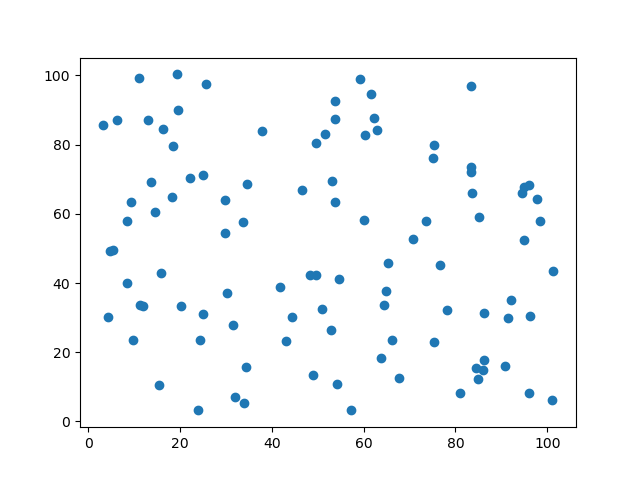

In [20]:
positionPlot(curr1)

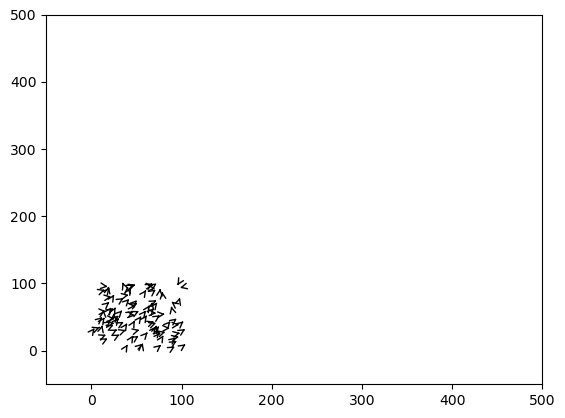

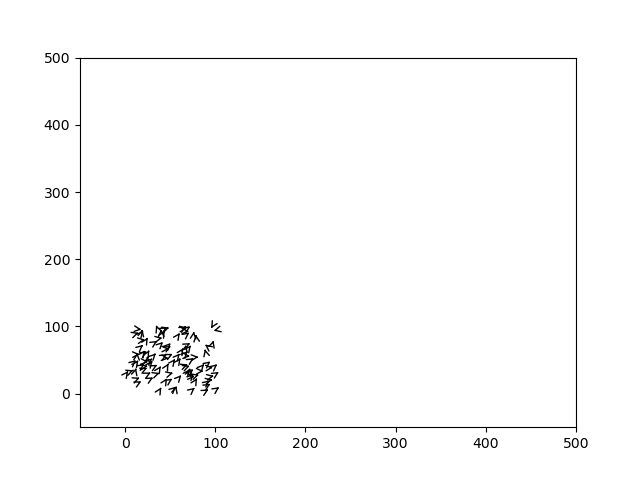

In [33]:
velPlot(curr2, next)

In [9]:
for i in range(100):
  sim.tick()
  fig = velPlot(sim)
  #num = str(i).rjust(3, '0')
  #fig.savefig(f'{num}.png')